## Active Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sbi
sbi.__version__

'0.18.0'

In [3]:
from sbi.inference import SNLE, SNPE
from sbi.utils import BoxUniform
from sbi.analysis import pairplot
from sbi.inference import MCMCPosterior, RejectionPosterior
from sbi.utils import mcmc_transform
from sbi.inference.potentials.base_potential import BasePotential
import matplotlib.pyplot as plt

In [4]:
import torch
from torch import ones, zeros, eye

In [5]:
prior = BoxUniform(-ones(2), ones(2))
def sim(theta):
    return theta + torch.randn(theta.shape) * 0.2

In [6]:
class AcquisitionPotential(BasePotential):
    allow_iid_x = False
    def __init__(self, prior, x_o, device="cpu"):
        super().__init__(prior, x_o, device)
    
    def __call__(self, theta, track_gradients=True):
        return acquisition_fn(theta)


In [59]:
from loss_calibration.loss import StepLoss_weighted
loss_fn = StepLoss_weighted([2,1], 0.)

In [60]:
# def loss_fn(true_theta, sampled_theta):
#     costs = []
#     for s in sampled_theta:
#         if true_theta[0, 0] < 0.0:
#             if s[0] < 0.0:
#                 costs.append(torch.tensor([0.01]))
#             else:
#                 costs.append(torch.tensor([1.0]))
#         else:
#             if s[0] > 0.0:
#                 costs.append(torch.tensor([0.01]))
#             else:
#                 costs.append(torch.tensor([1.0]))
#     return torch.cat(costs)

In [66]:
num_monte_carlo_samples_likelihood = 5
num_monte_carlo_samples_posterior = 1

    
def acquisition_fn(theta_0):
    predicted_x = likelihood_estimator.sample(num_monte_carlo_samples_likelihood, context=theta_0)[0] 
    predicted_theta_given_x = []
    for px in predicted_x: #lässt sich der loop eliminieren?
        predicted_theta_given_x.append(posterior_estimator.sample(num_monte_carlo_samples_posterior, context=px.unsqueeze(0))[0])
    predicted_theta_given_x = torch.cat(predicted_theta_given_x)
    predicted_decision = (predicted_theta_given_x > 0.).float()
    estimated_cost = loss_fn(theta_0[:,0], predicted_decision[:,0])
    #estimated_cost = loss_fn(theta_0, predicted_theta_given_x)
    return estimated_cost.mean()

# can handle batches: 
def acquisition_fn_batches(theta_0):
    predicted_x = likelihood_estimator.sample(num_monte_carlo_samples_likelihood, context=theta_0) 
    predicted_theta_given_x = []
    for px in predicted_x.swapaxes(0,1): #lässt sich der loop eliminieren? nein, weil posterior_sample nicht mit 3 dim umgehen kann
        predicted_theta_given_x.append(posterior_estimator.sample(num_monte_carlo_samples_posterior, context=px))
    predicted_theta_given_x = torch.cat(predicted_theta_given_x, dim=1) 
    predicted_decision = (predicted_theta_given_x > 0.).float()
    #estimated_cost = loss_fn(theta_0[:,0].unsqueeze(1).repeat(1,num_monte_carlo_samples_likelihood), predicted_decision[:,:,0])
    estimated_cost = loss_fn(theta_0, predicted_theta_given_x)
    return estimated_cost.mean(dim=1)

In [62]:
n_rounds = 1
proposal = prior

# inference objects
inference_likelihood = SNLE(prior)
inference_posterior = SNPE(prior)

for r in range(n_rounds): # rounds
    theta = proposal.sample((1000,))
    x = sim(theta)
    # train both SNLE and SNPE
    likelihood_estimator = inference_likelihood.append_simulations(theta, x).train(max_num_epochs=100)
    posterior_estimator = inference_posterior.append_simulations(theta, x, proposal=proposal).train(max_num_epochs=100)

    # potential = AcquisitionPotential(prior, zeros(1, 2), device="cpu")
    # prior_tf = mcmc_transform(prior)
    # acquisition_sampler = MCMCPosterior(potential_fn=potential, theta_transform=prior_tf, proposal=prior, init_strategy="proposal", method="slice_np")
    # proposal = acquisition_sampler


 Training neural network. Epochs trained: 10191 epochs.

### Batch Handling

In [ ]:
# can acquisition_fn handle btaches? 
th_0 = prior.sample((1,))
th_0.shape, likelihood_estimator.sample(num_monte_carlo_samples_likelihood, context=th_0).shape

In [ ]:
theta_0 = prior.sample((3,))
theta_0

In [ ]:
predicted_x = likelihood_estimator.sample(num_monte_carlo_samples_likelihood, context=theta_0) # shape: context[0], num_samples, context[1]
predicted_theta_given_x = []
for px in predicted_x.swapaxes(0,1): #lässt sich der loop eliminieren? nein, weil posterior_sample nicht mit 3 dim umgehen kann
    # px shape: context[0], context[1]
    post_sample = posterior_estimator.sample(num_monte_carlo_samples_posterior, context=px) # shape: context[0], 1, context[1]
    predicted_theta_given_x.append(post_sample)
predicted_theta_given_x = torch.cat(predicted_theta_given_x, dim=1) # shape: context[0], num_samples, context[1]
predicted_decision = (predicted_theta_given_x > 0.).float()
estimated_cost = loss_fn(theta_0[:,0].unsqueeze(1).repeat(1,5), predicted_decision[:,:,0])
print("estimated_cost", estimated_cost)
print("mean", estimated_cost.mean(dim=1))

In [ ]:
def acquisition_fn(theta_0):
    print("theta_0", theta_0.shape)
    predicted_x = likelihood_estimator.sample(num_monte_carlo_samples_likelihood, context=theta_0)[0]
    print("predicted_x", predicted_x.shape)
    predicted_theta_given_x = []
    for px in predicted_x: #lässt sich der loop eliminieren?
        predicted_theta_given_x.append(posterior_estimator.sample(num_monte_carlo_samples_posterior, context=px.unsqueeze(0))[0])
    predicted_theta_given_x = torch.cat(predicted_theta_given_x)
    predicted_decision = (predicted_theta_given_x > 0.).float()
    estimated_cost = loss_fn(theta_0[:,0], predicted_decision[:,0])
    print(theta_0[:,0].shape, predicted_decision[:,0].shape)
    print("estimated_cost", estimated_cost.shape)
    return estimated_cost.mean()

In [ ]:
for th in theta_0[:1]:
    print(acquisition_fn(th.unsqueeze(0)))

In [ ]:
# for each theta, likelihood_estimator samples n samples


In [ ]:
th_0 = prior.sample((1,))
xx = likelihood_estimator.sample(5, context=th_0)
print("xx", xx.shape)
for x in xx.swapaxes(0,1):
    th = posterior_estimator.sample(1, context=x) # loop over dim 1 (all x)
    print("x", x.shape)
    print("th", th.squeeze(dim=1).shape)

In [ ]:
posterior_estimator.sample(1, context=xx[:,1,:]).shape

### Continued

In [67]:
potential = AcquisitionPotential(prior, zeros(1, 2), device="cpu")
prior_tf = mcmc_transform(prior)
acquisition_sampler = MCMCPosterior(potential_fn=potential, theta_transform=prior_tf, proposal=prior, init_strategy="proposal", method="slice_np")#, num_chains=100)
# proposal = prior oder proposal = proposal??
# MCMCPosterior gegen RejectionPosterior tauschen, ggf. schneller
# wenn acquisition_fn+loss_fn vectorized, use method = slice_np_vectorized + num_cahins = 100
proposal = acquisition_sampler

In [68]:
# shapes dont fit
# aa = torch.linspace(-1,1,100)
# plt.plot(aa, torch.cat([potential(a.unsqueeze(0).unsqueeze(0)).unsqueeze(0) for a in aa]))

In [69]:
samples = proposal.sample((10,))

Generating samples: 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


In [70]:
for aa in samples:
    print(f"sample {aa} \tpotential {potential(aa.unsqueeze(0)).item():.3f}")

sample tensor([-0.0280,  0.4252]) 	potential 0.600
sample tensor([-0.1584,  0.5626]) 	potential 0.400
sample tensor([0.5919, 0.1166]) 	potential 0.000
sample tensor([ 0.6887, -0.7672]) 	potential 0.000
sample tensor([-0.0179, -0.6287]) 	potential 0.600
sample tensor([ 0.3792, -0.7839]) 	potential 0.400
sample tensor([-0.3888, -0.3527]) 	potential 0.000
sample tensor([0.3166, 0.9095]) 	potential 0.000
sample tensor([0.1044, 0.4243]) 	potential 1.200
sample tensor([ 0.1350, -0.6208]) 	potential 0.000


In [71]:
prior_samples = prior.sample((10,))
# for aa in prior_samples:
#     print("prior", potential(aa.unsqueeze(0)))

potentials:  [0.6, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.4, 0.8]


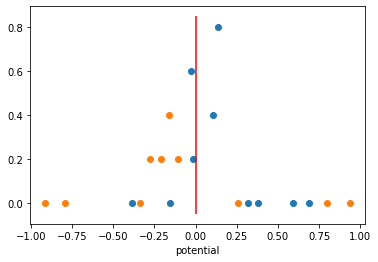

In [77]:
samples_potentials = [potential(aa.unsqueeze(0)).item()  for aa in samples]
prior_potentials = [potential(aa.unsqueeze(0)).item()  for aa in prior_samples]
print("potentials: ", list(map(lambda p: round(p,3), samples_potentials)))
plt.scatter(samples[:,0], samples_potentials)
plt.scatter(prior_samples[:,0], prior_potentials)
plt.xlabel('first element of samples')
plt.xlabel('potential')
plt.vlines(0.0, ymin=-0.05, ymax=max(samples_potentials+prior_potentials)+0.05, color='r')
plt.show()